In [ ]:
import glob
import cv2
import imutils
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
from skimage import io

num_list=[1,2,3,4,5]
print(num_list)

images = []
for i in num_list:
    file = '/content/sample_data/iris/aeval'+str(i)+'.bmp'
    im = cv2.imread(file)
    im = cv2.resize(im ,(160,120))
    images.append(im)
print(len(images))
#cv2_imshow(images[0])

[1, 2, 3, 4, 5]
5


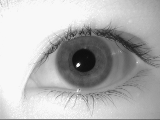

Image after gaussian blur and canny edge detection--


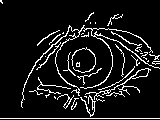

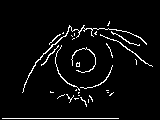

In [ ]:
img = images[1]
img = cv2.resize(img ,(160,120))
output = img.copy()
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray_image)


image_test = cv2.GaussianBlur(gray_image, (7, 7), 1)
image_test = cv2.Canny(image_test, 20, 70, apertureSize=3)
print("Image after gaussian blur and canny edge detection--")
cv2_imshow(image_test)

hough_circle = cv2.HoughCircles(image_test, cv2.HOUGH_GRADIENT, 1.3, 800)
if hough_circle is not None:
    hough_circle = np.round(hough_circle[0, :]).astype("int")
    for (x, y, radius) in hough_circle:
        cv2.circle(output, (x, y), radius, (255, 0, 0), 4)
		
image_test = gray_image
image_test = cv2.GaussianBlur(image_test, (7, 7), 1)
image_test = cv2.Canny(image_test, 100, 120, apertureSize=3)
cv2_imshow(image_test)

circles = cv2.HoughCircles(image_test,cv2.HOUGH_GRADIENT,1,800,
                            param1=50,param2=20,minRadius=0,maxRadius=60)
circles = np.round(circles[0, :]).astype("int")
 
for (x, y, r) in circles:
		cv2.circle(output, (x, y), r, (0, 255, 0), 2)
		cv2.rectangle(output, (x - 2, y - 2), (x + 2, y + 2), (0, 128, 255), -1)

#cv2_imshow(output)

Image after grayscaling--


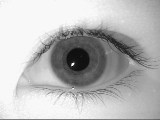

Image after gaussian blur and canny edge detection--


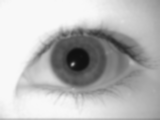

Image after finding edges using Intensity gradient--


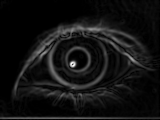

Image after applying Non-max suppression--


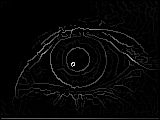

Image after applying hysteresis thresholding--


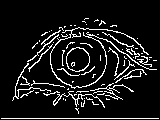

1
78 58 28
Detecting iris----


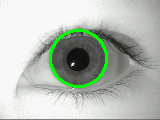

Segmenting iris part only----


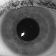

In [ ]:
img = images[0]
img = cv2.resize(img ,(160,120))
output = img.copy()
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print("Image after grayscaling--")
cv2_imshow(gray_image)

image_test = cv2.Canny(gray_image, 20, 70, apertureSize=3)
image_test = cv2.GaussianBlur(gray_image, (7, 7), 1)
#image_test = adjust_gamma(image_test,0.5)
print("Image after gaussian blur and canny edge detection--")
cv2_imshow(image_test)

#---------------------------------------------------------------------------------------------
# Apply Sobelx in high output datatype 'float32'
# and then converting back to 8-bit to prevent overflow
sobelx_64 = cv2.Sobel(image_test,cv2.CV_32F,1,0,ksize=3)
absx_64 = np.absolute(sobelx_64)
sobelx_8u1 = absx_64/absx_64.max()*255
sobelx_8u = np.uint8(sobelx_8u1)

# Similarly for Sobely
sobely_64 = cv2.Sobel(image_test,cv2.CV_32F,0,1,ksize=3)
absy_64 = np.absolute(sobely_64)
sobely_8u1 = absy_64/absy_64.max()*255
sobely_8u = np.uint8(sobely_8u1)

# From gradients calculate the magnitude and changing
# it to 8-bit (Optional)
mag = np.hypot(sobelx_8u, sobely_8u)
mag = mag/mag.max()*255
mag = np.uint8(mag)

# Find the direction and change it to degree
theta = np.arctan2(sobely_64, sobelx_64)
angle = np.rad2deg(theta)
print("Image after finding edges using Intensity gradient--")
cv2_imshow(mag)
# Find the neighbouring pixels (b,c) in the rounded gradient direction
# and then apply non-max suppression
M, N = mag.shape
Non_max = np.zeros((M,N), dtype= np.uint8)

for i in range(1,M-1):
    for j in range(1,N-1):
       # Horizontal 0
        if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180) or (-22.5 <= angle[i,j] < 0) or (-180 <= angle[i,j] < -157.5):
            b = mag[i, j+1]
            c = mag[i, j-1]
        # Diagonal 45
        elif (22.5 <= angle[i,j] < 67.5) or (-157.5 <= angle[i,j] < -112.5):
            b = mag[i+1, j+1]
            c = mag[i-1, j-1]
        # Vertical 90
        elif (67.5 <= angle[i,j] < 112.5) or (-112.5 <= angle[i,j] < -67.5):
            b = mag[i+1, j]
            c = mag[i-1, j]
        # Diagonal 135
        elif (112.5 <= angle[i,j] < 157.5) or (-67.5 <= angle[i,j] < -22.5):
            b = mag[i+1, j-1]
            c = mag[i-1, j+1]           
            
        # Non-max Suppression
        if (mag[i,j] >= b) and (mag[i,j] >= c):
            Non_max[i,j] = mag[i,j]
        else:
            Non_max[i,j] = 0

print("Image after applying Non-max suppression--")
cv2_imshow(Non_max)

# Set high and low threshold
highThreshold = 21
lowThreshold = 15

M, N = Non_max.shape
out = np.zeros((M,N), dtype= np.uint8)

# If edge intensity is greater than 'High' it is a sure-edge
# below 'low' threshold, it is a sure non-edge
strong_i, strong_j = np.where(Non_max >= highThreshold)
zeros_i, zeros_j = np.where(Non_max < lowThreshold)

# weak edges
weak_i, weak_j = np.where((Non_max <= highThreshold) & (Non_max >= lowThreshold))

# Set same intensity value for all edge pixels
out[strong_i, strong_j] = 255
out[zeros_i, zeros_j ] = 0
out[weak_i, weak_j] = 75

M, N = out.shape
for i in range(1, M-1):
    for j in range(1, N-1):
        if (out[i,j] == 75):
            if 255 in [out[i+1, j-1],out[i+1, j],out[i+1, j+1],out[i, j-1],out[i, j+1],out[i-1, j-1],out[i-1, j],out[i-1, j+1]]:
                out[i, j] = 255
            else:
                out[i, j] = 0
print("Image after applying hysteresis thresholding--")
cv2_imshow(out)
#---------------------------------------------------------------------------------------------
circles = cv2.HoughCircles(out,cv2.HOUGH_GRADIENT,1,50,
                            param1=50,param2=50,minRadius=0,maxRadius=35)
print(len(circles))
circles = np.round(circles[0, :]).astype("int")
cx=0
cy=0
cr=0
for (x, y, r) in circles:
		# draw the circle in the output image, then draw a rectangle
		# corresponding to the center of the circle
    cx = x
    cy = y
    cr = r
    cv2.circle(output, (x, y), r, (0, 255, 0), 2)
		#cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)

#cv2.imshow('detected circles',output)
print(x,y,r)
print("Detecting iris----")
cv2_imshow(output)
output1 = gray_image[cy-cr:cy+cr , cx-cr:cx+cr]
print("Segmenting iris part only----")
cv2_imshow(output1)

Gabor Filtering--


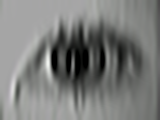

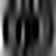

In [ ]:
def build_filters():
        filters = []
        ksize = 31
        for theta in np.arange(0, np.pi, np.pi / 16):
            kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
            kern /= 1.5*kern.sum()
            filters.append(kern)
            return filters

def process(img, filters):
        accum = np.zeros_like(img)
        for kern in filters:
            fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
            np.maximum(accum, fimg, accum)
            return accum

filters=build_filters()
res1=process(img,filters)
res2=process(output1,filters)
print("Gabor Filtering--")
cv2_imshow(res1)
cv2_imshow(res2)

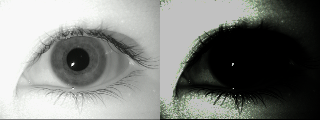

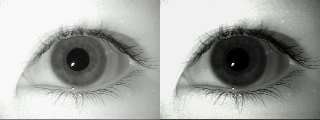

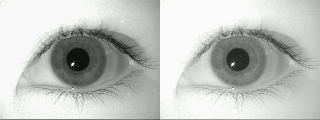

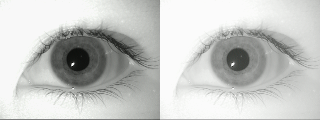

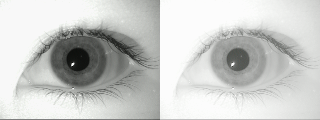

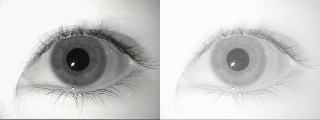

In [ ]:
from __future__ import print_function
import numpy as np
import argparse
import cv2

def adjust_gamma(image, gamma=1.0):
	# build a lookup table mapping the pixel values [0, 255] to
	# their adjusted gamma values
	invGamma = 1.0 / gamma
	table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")
	# apply gamma correction using the lookup table
	return cv2.LUT(image, table)

original = images[0]
for gamma in np.arange(0.0, 3.5, 0.5):
	# ignore when gamma is 1 (there will be no change to the image)
	if gamma == 1:
		continue
	# apply gamma correction and show the images
	gamma = gamma if gamma > 0 else 0.1
	adjusted = adjust_gamma(original, gamma=gamma)
	#cv2.putText(adjusted, "g={}".format(gamma), (10, 30),
	#	cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 3)
	cv2_imshow(np.hstack([original, adjusted]))